# Why are the measures so similar?

If the voltage shapes are very similar, then $(V-E_{Na})$ is just a proportionality factor. In that case, both metrics will be very similar.

What if the voltage shapes are not similar, e.g. one spike is high and one is low? The big part of the energy is consumed when $(V - E_{Na})$ is large, i.e. in the regime where the spikes are still in their "early phase". This phase exists in both high and low spikes and within this range, the voltage waveforms are very similar. The difference in voltage waveforms only appears at high voltages (one spike still increasing, other flattening out). However, in this regime, the consumed energy is generally low due to a low $(V - E_{Na})$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyloric import simulate, create_prior, summary_stats
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import torch
from matplotlib.patches import Rectangle
import stg_energy.fig1_energy.viz_appendix as viz
from sklearn.linear_model import LinearRegression

prior = create_prior()

In [3]:
def simulate_(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        track_currents=True,
        energy_measure="power"
    )
    custom_stats = {
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
        "spike_heights": True,
    }
    return summary_stats(out_target, stats_customization=custom_stats, t_burn_in=1000)

In [4]:
def simulate_calcium(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        track_currents=True,
        track_calcium=True,
        energy_measure="power"
    )
    return out_target

In [5]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

In [6]:
n_samp = 100
samples = theta[:n_samp]
data_np = samples.to_numpy()
params_with_seeds = np.concatenate((data_np, np.expand_dims(seeds[:n_samp], axis=1)), axis=1)

In [7]:
with Pool(1) as pool:
    start_time = time.time()
    data1 = pool.map(simulate_calcium, params_with_seeds)
    print("Simulation time", time.time() - start_time)

Simulation time 391.06010484695435


# Sodium

In [8]:
time_vec = np.arange(0, 11000, 0.025)

In [9]:
intracellular_calcium_abpd = np.asarray([np.mean(d["intracellular_calcium"][0][40000:]) for d in data1])
energies_pd = np.asarray([np.sum(d["energy"][0][40000:]) / 1000 * 0.025 for d in data1])
energies_pd = np.asarray(energies_pd).astype(float)

rho_pd = np.corrcoef(intracellular_calcium_abpd, energies_pd)[0, 1]

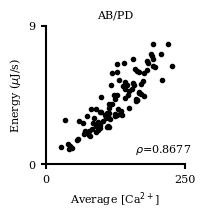

In [10]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    _ = ax.scatter(intracellular_calcium_abpd, energies_pd / 1000 / 10, c="k")
    ax.set_xlabel(r"Average [Ca$^{2+}$]")
    ax.set_ylabel(r"Energy ($\mu$J/s)")
    ax.text(160.0, 0.8, r"$\rho$" + f"={rho_pd:.4f}")
    ax.set_xlim([0, 250])
    ax.set_ylim([0, 9])
    ax.set_xticks([0, 250])
    ax.set_yticks([0, 9])
    ax.set_title("AB/PD")
    plt.savefig("../svg/panel_explanation_of_proportionality_g1.svg")

In [11]:
intracellular_calcium_lp = np.asarray([np.mean(d["intracellular_calcium"][1][40000:]) for d in data1])
energies_lp = np.asarray([np.sum(d["energy"][1][40000:]) / 1000 * 0.025 for d in data1])
energies_lp = np.asarray(energies_lp).astype(float)

rho_lp = np.corrcoef(intracellular_calcium_lp, energies_lp)[0, 1]

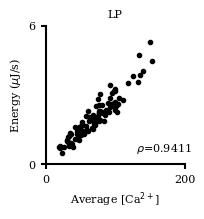

In [12]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    _ = ax.scatter(intracellular_calcium_lp, energies_lp / 1000 / 10, c="k")
    ax.set_xlabel(r"Average [Ca$^{2+}$]")
    ax.set_ylabel(r"Energy ($\mu$J/s)")
    ax.text(130.0, 0.55, r"$\rho$" + f"={rho_lp:.4f}")
    ax.set_xlim([0, 200])
    ax.set_ylim([0, 6])
    ax.set_xticks([0, 200])
    ax.set_yticks([0, 6])
    ax.set_title("LP")
    plt.savefig("../svg/panel_explanation_of_proportionality_g2.svg")

In [13]:
intracellular_calcium_py = np.asarray([np.mean(d["intracellular_calcium"][2][40000:]) for d in data1])
energies_py = np.asarray([np.sum(d["energy"][2][40000:]) / 1000 * 0.025 for d in data1])
energies_py = np.asarray(energies_py).astype(float)

rho_py = np.corrcoef(intracellular_calcium_py, energies_py)[0, 1]

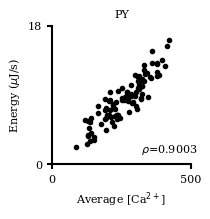

In [14]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    _ = ax.scatter(intracellular_calcium_py, energies_py / 1000 / 10, c="k")
    ax.set_xlabel(r"Average [Ca$^{2+}$]")
    ax.set_ylabel(r"Energy ($\mu$J/s)")
    ax.text(320.0, 1.55, r"$\rho$" + f"={rho_py:.4f}")
    ax.set_xlim([0, 500])
    ax.set_ylim([0, 18])
    ax.set_xticks([0, 500])
    ax.set_yticks([0, 18])
    ax.set_title("PY")
    plt.savefig("../svg/panel_explanation_of_proportionality_g3.svg")

## Assemble figure

In [15]:
import IPython.display as IPd
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [19]:
from svgutils.compose import *
import svgutils.transform as sg

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "5.0cm",

    Panel(
          SVG("../svg/panel_explanation_of_proportionality_g1.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(0*factor_svg, 0*factor_svg),
           
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_g2.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(35*factor_svg, 0*factor_svg),
    
    Panel(
          SVG("../svg/panel_explanation_of_proportionality_g3.svg").scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(70*factor_svg, 0*factor_svg),
)

f.save("../fig/fig1_supp_explanation6.svg")
svg('../fig/fig1_supp_explanation6.svg')